# DATASET VIAJES DE TAXIS
El dataset representa viajes de taxi en Filadelfia, mostrando la duración, distancia, velocidad, costos detallados (espera, distancia, banderazo, cargos extra), propinas y el precio total final.

 En este caso la columna **total_fare_new → tarifa total pagada (suma de los costos + propina + otros cargos)** ya no la vamos a utilizar como feature (X), porque de ahí justamente construimos la variable objetivo fare_class (y). i incluyéramos total_fare_new en las variables de entrada, el modelo estaría "viendo" directamente la respuesta que queremos predecir, lo cual haría que el entrenamiento sea tramposo. Entonces mis "X" e "y" son las siguientes.

y = fare_class -> categoria del Viaje (Baja, Media, Alta).

x1 = trip_duration_sec → duración del viaje en segundos.

x2 = trip_duration_min → duración en minutos.

x3 = trip_duration_hr → duración en horas.

x4 = distance_traveled_Km → distancia recorrida (km).

x5 = KPH → velocidad promedio (km/h).

x6 = wait_time_cost → costo por espera.

x7 = distance_cost → costo por distancia.

x8 = fare_w_flag → tarifa base incluida.

x9 = tip → propina del viaje.

x10 = miscellaneous_fees → otros cargos.

x11 = num_of_passengers → número de pasajeros.

x12 = surge_applied → si se aplicó tarifa dinámica (binario).

# IMPORTACION DE LIBRERIAS

In [15]:
# utilizado para manejos de directorios y rutas
import os

# Computacion vectorial y cientifica para python
import numpy as np

import pandas as pd

# Librerias para graficación (trazado de gráficos)
from matplotlib import pyplot as plt
from scipy import optimize
from mpl_toolkits.mplot3d import Axes3D  # Necesario para graficar superficies 3D
from sklearn.metrics import classification_report, confusion_matrix

# llama a matplotlib a embeber graficas dentro de los cuadernillos
%matplotlib inline

# **Montar el Drive en el Cuadernillo**

In [3]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: Error: credential propagation was unsuccessful

# **Leer el dataset**

In [4]:
# Leer datos separados por una coma
# data = np.loadtxt('ex1data1.txt', delimiter=',')
# data = np.loadtxt(os.path.join('data', 'ex1data1.txt'), delimiter=',')
df = pd.read_csv('/content/drive/MyDrive/Datasets/Taxi_Set.csv')
#df = pd.read_csv('Taxi_Set.csv')

# Incorporacion al Dataset la nueva columna fare_class en base a total_fare_new con los siguientes rangos
# Bajo → viajes de $3.16 a $25.89
# Medio → viajes de $25.90 a $48.61
# Alto → viajes de $48.62 a $2539.32
df['fare_class'] = pd.qcut(df['total_fare_new'], q=3, labels=["Baja", "Media", "Alta"])

# Mostrar 'total_fare_new' y  'fare_class'
df[['total_fare_new', 'fare_class']]

,total_fare_new,fare_class
0,42.24,Media
1,53.12,Alta
2,39.03,Media
3,25.66,Baja
4,33.34,Media
...,...,...
207591,79.33,Alta
207592,54.19,Alta
207593,16.88,Baja
207594,22.82,Baja


In [5]:
df['fare_class_code'] = pd.Categorical(df['fare_class'], categories=["Baja", "Media", "Alta"]).codes
y_all = df['fare_class_code'].values

features = [
    'trip_duration_sec', 'trip_duration_min', 'trip_duration_hr',
    'distance_traveled_Km', 'KPH', 'wait_time_cost', 'distance_cost',
    'fare_w_flag', 'tip', 'miscellaneous_fees', 'num_of_passengers', 'surge_applied'
]

X_all = df[features].copy()

In [6]:
# --- 4) LIMPIEZA / CONVERSIÓN DE FLAGS A NUMÉRICO ---
def bool_to_int_series(s):
    # maneja True/False booleanos y strings 'TRUE'/'FALSE' u otras variantes
    if s.dtype == 'bool' or s.dtype == np.bool_:
        return s.astype(int)
    # si ya es numérico
    if np.issubdtype(s.dtype, np.number):
        return s.fillna(0).astype(int)
    # normalizar strings
    s2 = s.astype(str).str.strip().str.upper()
    return s2.map({'TRUE':1,'FALSE':0,'1':1,'0':0, 'YES':1, 'NO':0}).fillna(0).astype(int)

# aplicar para las columnas binarias
X_all['surge_applied'] = bool_to_int_series(X_all['surge_applied'])

In [7]:
# rellenar NA numéricos si hay
X_all = X_all.fillna(0)

# convertir a numpy
X_all = X_all.values.astype(float)
y_all = y_all.astype(int)

m_all = X_all.shape[0]
print(f"Ejemplos totales: {m_all}, features: {X_all.shape[1]}")

Ejemplos totales: 207596, features: 12


In [8]:
# --- 5) DIVIDIR EN ENTRENAMIENTO / PRUEBA (80% / 20%) ---
perm = np.random.permutation(m_all)
cut = int(0.8 * m_all)
train_idx = perm[:cut]
test_idx = perm[cut:]

X_train = X_all[train_idx, :]
y_train = y_all[train_idx]
X_test  = X_all[test_idx, :]
y_test  = y_all[test_idx]

print(f"Train: {X_train.shape[0]} ejemplos, Test: {X_test.shape[0]} ejemplos")

Train: 166076 ejemplos, Test: 41520 ejemplos


In [9]:
# --- 6) NORMALIZACIÓN (usando parámetros del conjunto de entrenamiento) ---
mu = X_train.mean(axis=0)
sigma = X_train.std(axis=0)
# evitar división por cero
sigma[sigma == 0] = 1.0

X_train_norm = (X_train - mu) / sigma
X_test_norm  = (X_test - mu) / sigma

In [10]:
# --- 7) FUNCIONES DE REGRESIÓN LOGÍSTICA (mismo estilo que tu ejemplo) ---
def sigmoid(z):
    return 1.0 / (1.0 + np.exp(-z))

def lrCostFunction(theta, X, y, lambda_):
    """
    theta: (n+1,)  (vector)
    X:     (m, n+1)  (ya con columna de 1s si corresponde)
    y:     (m,) boolean / 0-1
    lambda_: regularización
    Devuelve J, grad
    """
    m = y.size
    if y.dtype == bool:
        y = y.astype(int)

    h = sigmoid(X.dot(theta))
    # evitar log(0)
    eps = 1e-12
    J = (1.0 / m) * ( - y.dot(np.log(h + eps)) - (1 - y).dot(np.log(1 - h + eps)) )

    temp = theta.copy()
    temp[0] = 0.0  # no regularizar theta0
    J = J + (lambda_ / (2.0 * m)) * np.sum(temp**2)

    grad = (1.0 / m) * (X.T.dot(h - y))
    grad = grad + (lambda_ / m) * temp
    return J, grad

def oneVsAll(X, y, num_labels, lambda_, maxiter=50):
    """
    Entrena num_labels clasificadores (one-vs-all).
    Devuelve all_theta (K x n+1) y histories (lista con historiales de costo por clase).
    """
    m, n = X.shape
    all_theta = np.zeros((num_labels, n + 1))
    histories = []

    # agregar columna de 1s
    X_with_bias = np.concatenate([np.ones((m, 1)), X], axis=1)

    for c in range(num_labels):
        initial_theta = np.zeros(n + 1)
        history = []

        # wrapper para guardar histórico:
        def cost_and_grad(th, X_arg, y_arg, lambda_arg):
            J, g = lrCostFunction(th, X_arg, y_arg, lambda_arg)
            history.append(J)
            return J, g

        options = {'maxiter': maxiter}
        res = optimize.minimize(fun=cost_and_grad,
                                x0=initial_theta,
                                args=(X_with_bias, (y == c).astype(int), lambda_),
                                jac=True,
                                method='CG',
                                options=options)

        all_theta[c, :] = res.x
        histories.append(np.array(history))
        print(f"Clase {c}: exit status {res.success}, iter {len(history)}, final J {history[-1] if len(history)>0 else None}")

    return all_theta, histories

def predictOneVsAll(all_theta, X):
    m = X.shape[0]
    X_with_bias = np.concatenate([np.ones((m, 1)), X], axis=1)
    probs = sigmoid(X_with_bias.dot(all_theta.T))  # (m, K)
    p = np.argmax(probs, axis=1)
    return p

In [11]:
# --- 8) ENTRENAMIENTO ---
num_labels = 3  # Baja, Media, Alta
lambda_ = 0.1
maxiter = 100  # aumenta si quieres mejor convergencia

all_theta, histories = oneVsAll(X_train_norm, y_train, num_labels, lambda_, maxiter=maxiter)

# --- 9) PREDICCIONES Y MÉTRICAS ---
pred_train = predictOneVsAll(all_theta, X_train_norm)
pred_test  = predictOneVsAll(all_theta, X_test_norm)

acc_train = np.mean(pred_train == y_train) * 100
acc_test  = np.mean(pred_test  == y_test)  * 100

print(f"Precisión (train): {acc_train:.2f}%")
print(f"Precisión (test) : {acc_test:.2f}%")

print("\nReporte clasificación (test):")
print(classification_report(y_test, pred_test, target_names=["Baja","Media","Alta"]))

print("Matriz de confusión (test):")
print(confusion_matrix(y_test, pred_test))

/tmp/ipython-input-1317079299.py:3: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-z))


Clase 0: exit status False, iter 492, final J 0.010451444017228667
Clase 1: exit status True, iter 44, final J 0.6057499684090458
Clase 2: exit status False, iter 461, final J 0.006718676413568359
Precisión (train): 99.55%
Precisión (test) : 99.50%

Reporte clasificación (test):
              precision    recall  f1-score   support

        Baja       0.99      1.00      1.00     13873
       Media       1.00      0.99      0.99     13908
        Alta       0.99      1.00      1.00     13739

    accuracy                           0.99     41520
   macro avg       1.00      1.00      0.99     41520
weighted avg       1.00      0.99      0.99     41520

Matriz de confusión (test):
[[13873     0     0]
 [   76 13700   132]
 [    0     0 13739]]


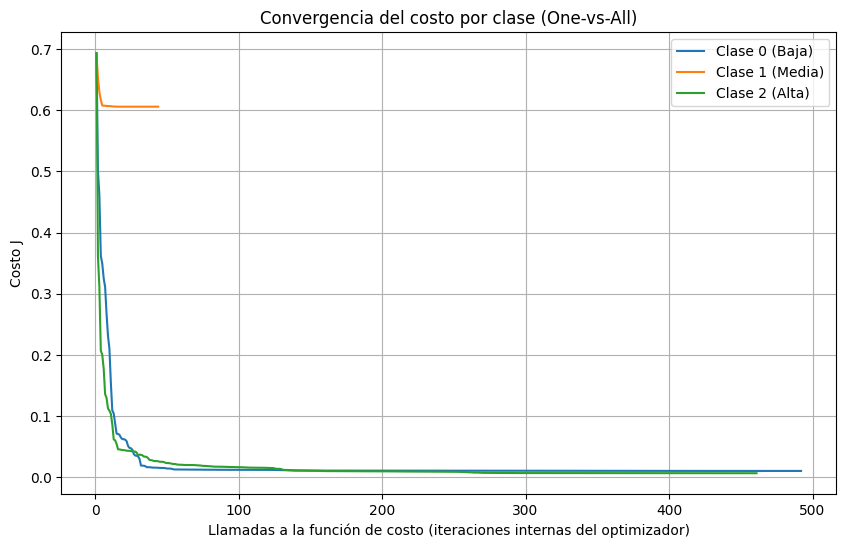

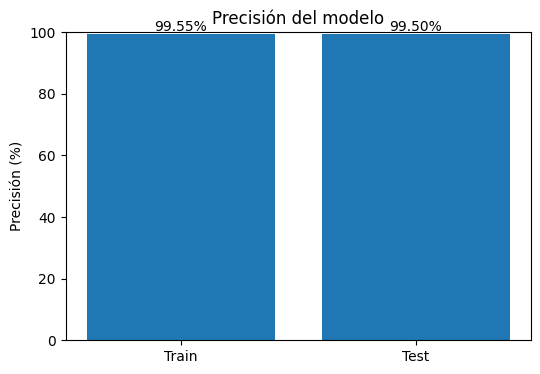

Ejemplos de test (primeros 12) -> pred / real
 0: pred=Media 	 real=Media
 1: pred=Media 	 real=Media
 2: pred=Alta 	 real=Alta
 3: pred=Media 	 real=Media
 4: pred=Media 	 real=Media
 5: pred=Media 	 real=Media
 6: pred=Baja 	 real=Baja
 7: pred=Media 	 real=Media
 8: pred=Baja 	 real=Baja
 9: pred=Baja 	 real=Baja
10: pred=Alta 	 real=Alta
11: pred=Alta 	 real=Alta


In [12]:
# --- 10) GRAFICOS ---
# a) Costo por iteración (cada clase)
plt.figure(figsize=(10,6))
maxlen = max(len(h) for h in histories)
for i, h in enumerate(histories):
    # hacer x: número de llamadas (itera)
    x = np.arange(1, len(h)+1)
    plt.plot(x, h, label=f'Clase {i} ({["Baja","Media","Alta"][i]})')
plt.xlabel('Llamadas a la función de costo (iteraciones internas del optimizador)')
plt.ylabel('Costo J')
plt.title('Convergencia del costo por clase (One-vs-All)')
plt.legend()
plt.grid(True)
plt.show()

# b) Precisión train vs test
plt.figure(figsize=(6,4))
plt.bar(['Train','Test'], [acc_train, acc_test])
plt.ylim(0, 100)
plt.ylabel('Precisión (%)')
plt.title('Precisión del modelo')
for i, v in enumerate([acc_train, acc_test]):
    plt.text(i, v + 1, f"{v:.2f}%", ha='center')
plt.show()

# --- 11) EJEMPLO: mostrar predicciones para algunos ejemplos de test ---
n_show = min(12, X_test_norm.shape[0])
print("Ejemplos de test (primeros {}) -> pred / real".format(n_show))
for i in range(n_show):
    print(f"{i:2d}: pred={['Baja','Media','Alta'][pred_test[i]]} \t real={['Baja','Media','Alta'][y_test[i]]}")
